## Open farm and run simple diagnostic


## Load packages

In [1]:
import time
start = time.time()

import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install odc-ui rasterstats

  Using cached odc_ui-0.2.0a3-py3-none-any.whl (15 kB)
  Using cached rasterstats-0.19.0-py3-none-any.whl (16 kB)
  Using cached jupyter_ui_poll-0.2.2-py2.py3-none-any.whl (9.0 kB)
  Using cached simplejson-3.19.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (144 kB)


In [2]:
%%time
from grits import humanbytes, get_field, get_lims, get_mms, query_l2a_items, xr_rasterize, calculate_indices

# the basic
from datetime import date 
from geogif import gif
import rich.table
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rioxarray as rio

# for PC, stac, xarray
import odc.stac
import stackstac
from xrspatial import zonal_stats

# From DEA
import sys
sys.path.append('/home/jovyan/PlanetaryComputerExamples/grasspace/deafrica-sandbox-notebooks/Tools/deafrica_tools/')
from plotting import display_map, rgb, map_shapefile

# packages that have to be installed every runtime
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

CPU times: user 2.63 s, sys: 844 ms, total: 3.47 s
Wall time: 18.9 s


## Área de análise
Using function get_field for 

1. for fields in a farm - OK
2. for a group in a group of farms - OK
3. for specific fields in a farm - OK
4. ToDo - for an entire farm - the simplest case, as if the polygon was already given straight from a file

In [3]:
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'


#### Área: Fazenda Uniguiri
**Column parte** contém as regiões

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


<Axes: >

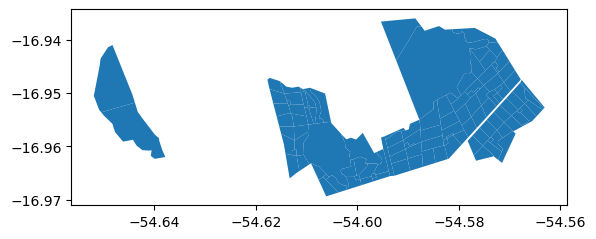

In [10]:

field = gpd.read_file( path + 'fazenda_uniguiri.gpkg', layer = 'piquetes_tid')

bbox, lat_range, lon_range = get_lims(field)

print(field.head())
field.plot()

#### Área: Iacanga - Cana

Grupo de talhoes dentro de todas fazendas de uma usina


In [4]:
# IACANGA FULL
field = gpd.read_file(path + 'iacanga_22_23.gpkg', layer = 'talhoes')
bbox, lat_range, lon_range = get_lims(field)

got bbox, lat_range, lon_range


### Display bbox study area


In [5]:
style={'opacity': 6, 'stroke': 2,'dashArray': '1', 'fillOpacity': 0.5}
map_shapefile(field,'AdMapKey',cmap='Set1', **style )

Label(value='')

Map(center=[-21.934511125091426, -49.143466247722145], controls=(ZoomControl(options=['position', 'zoom_in_tex…

## Get images

### get MODIS data
- LST
---
colocar as especificidades aqui

In [6]:
def query_modis_items(bbox, 
                    datetime,
                    collection):

    '''
        Query MODIS items for a given bounding box withing a 
        datetime range 
        bbox.:tuple with coordinates of the 2 corners of a bounding box: it is retrieved by the 
                get_lims function
        collection.:str: collection.
        ... product? band?
    '''
    
    import pystac_client
    import planetary_computer

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    
    search = catalog.search(bbox=bbox,
                            collections=collections,
                            datetime=datetime
                            )
    
    items = search.item_collection()
    print(f' found {len(items)} items')

    return items


In [8]:
%%time
collections = ["modis-11A2-061"]
# daterange analysis
datetime = "2012-08-10/2023-10-23"

items = query_modis_items(bbox, datetime, collections)

 found 1043 items
CPU times: user 1.15 s, sys: 46.4 ms, total: 1.19 s
Wall time: 4.72 s


In [17]:
collections = ["modis-11A1-061"]
# daterange analysis
datetime = "2023-06-10/" + str(date.today())

items = query_modis_items(bbox, datetime, collections)

 found 264 items


In [18]:
%%time
data = odc.stac.load(
    items,
    crs="EPSG:3857",
    bbox=bbox,
    bands=["LST_Day_1km","LST_Night_1km","QC_Day","QC_Night"],
    resolution=500,
)

data

CPU times: user 1min 11s, sys: 1min 13s, total: 2min 24s
Wall time: 1min 47s


<xarray.Dataset>
Dimensions:        (y: 117, x: 148, time: 132)
Coordinates:
  * y              (y) float64 -2.475e+06 -2.475e+06 ... -2.532e+06 -2.533e+06
  * x              (x) float64 -5.507e+06 -5.507e+06 ... -5.434e+06 -5.434e+06
    spatial_ref    int32 3857
  * time           (time) datetime64[ns] 2023-06-10 2023-06-11 ... 2023-10-19
Data variables:
    LST_Day_1km    (time, y, x) uint16 15068 15068 15068 15022 15022 ... 0 0 0 0
    LST_Night_1km  (time, y, x) uint16 14386 14375 14375 14372 14372 ... 0 0 0 0
    QC_Day         (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2
    QC_Night       (time, y, x) uint8 65 65 65 65 65 65 65 65 ... 2 2 2 2 2 2 2

In [19]:
humanbytes(data.nbytes)

'13.08 MB'

### Masks
- field
- values (trim)

In [22]:
mask = xr_rasterize(field,data,
                    # x_dim='x',
                    # y_dim='y',
                   #export_tiff='masked2.tiff',
                   ) 

# #mask data
datam = data.where(mask)

print(humanbytes(datam.nbytes))
datam

69.76 MB


<xarray.Dataset>
Dimensions:        (time: 132, y: 117, x: 148)
Coordinates:
  * y              (y) float64 -2.475e+06 -2.475e+06 ... -2.532e+06 -2.533e+06
  * x              (x) float64 -5.507e+06 -5.507e+06 ... -5.434e+06 -5.434e+06
    spatial_ref    int32 3857
  * time           (time) datetime64[ns] 2023-06-10 2023-06-11 ... 2023-10-19
Data variables:
    LST_Day_1km    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    LST_Night_1km  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    QC_Day         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    QC_Night       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

### reprojection

In [23]:
# REPROJECTION
datam = datam.rio.reproject('EPSG:4326')

### conversions

In [24]:
datam['LST_Day_1km'] = datam['LST_Day_1km'] * 0.02 - 273.15
datam['LST_Night_1km'] = datam['LST_Night_1km'] * 0.02 - 273.15
datam

<xarray.Dataset>
Dimensions:        (x: 152, y: 112, time: 132)
Coordinates:
  * x              (x) float64 -49.47 -49.47 -49.46 ... -48.82 -48.82 -48.81
  * y              (y) float64 -21.69 -21.7 -21.7 ... -22.17 -22.17 -22.18
  * time           (time) datetime64[ns] 2023-06-10 2023-06-11 ... 2023-10-19
    spatial_ref    int64 0
Data variables:
    LST_Day_1km    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    LST_Night_1km  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    QC_Day         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    QC_Night       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

### limites

In [26]:
# FOR LST in Celcius
datam2 = datam.copy()
datam2['LST_Day_1km'] = xr.where((datam["LST_Day_1km"]> 50) | (datam["LST_Day_1km"]< -10), np.nan, datam["LST_Day_1km"])
datam2['LST_Night_1km'] = xr.where((datam["LST_Night_1km"]> 50) | (datam["LST_Night_1km"]< -10), np.nan, datam["LST_Night_1km"])

humanbytes(datam2.nbytes)

'68.58 MB'

##### aqui vou tentar implementar um filtro QC=0
- primeiro ver como fica a serie original
- verificar uma seria diaria para o verao

In [29]:
datam2['LST_Day_1km'].loc['2023-09-30':]

<xarray.DataArray 'LST_Day_1km' (time: 20, y: 112, x: 152)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 -49.47 -49.47 -49.46 ... -48.82 -48.82 -48.81
  * y            (y) float64 -21.69 -21.7 -21.7 -21.71 ... -22.17 -22.17 -22.18
  * time         (time) datetime64[ns] 2023-09-30 2023-10-01 ... 2023-10-19
    spatial_ref  int64 0

In [36]:
plot = False
di,df = '2023-09-30',str(date.today())
if plot:

    g = datam2['LST_Day_1km'].loc[di:df].plot.imshow(
        cmap="RdBu_r", col="time", robust=True, col_wrap=3, size=4
    )
    datetimes = datam2['LST_Day_1km'].loc[di:df].time.to_pandas().dt.strftime("%D")
    print(datetimes)
    for ax, datetime in zip(g.axes.flat, datetimes):
        ax.set_title(datetime)

In [35]:
gif = False

if gif:
    gif(datam2['LST_Day_1km'], fps=1, cmap="RdBu_r")

## Criar zonas

In [37]:
datam3 = datam2.copy()

In [38]:
datam3 = datam3.rename({'x':'longitude', 'y':'latitude'})

Rasterizing to match xarray.DataArray dimensions (112, 152)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
CPU times: user 830 ms, sys: 4.35 ms, total: 835 ms
Wall time: 832 ms


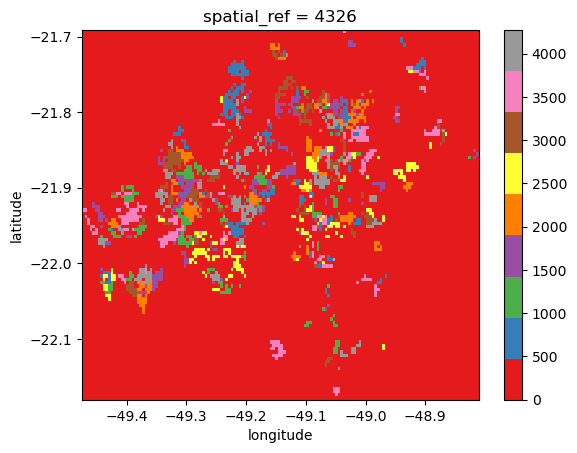

In [46]:
%%time
column = 'AdMapKey'
fm = xr_rasterize(field,datam3,attribute_col=column,verbose=True, 
                  **{'all_touched':False})
#fm = fm.chunk(2)
# fm = fm.astype('uint8')
# fm_f64 = fm.astype('float64')
# print(fm.values)
# print(fm_f64.values)
print(fm.values)
fm.plot(cmap='Set1')

In [47]:
len(np.unique(fm.values))

1868

### Calculate stats for IVs dataset

#### single image

In [48]:
allstats = pd.DataFrame(index=datam3['LST_Day_1km'].time.values)

t =  datam3['LST_Day_1km'].time.values[2]
print(t)

data_ = datam3['LST_Day_1km'].sel(time=t).squeeze()
outstats = zonal_stats(zones=fm, values=data_)#.compute()
#data_.close()
outstats 

2023-06-12T00:00:00.000000000


,zone,mean,max,min,sum,std,var,count
0,0,27.192928,31.57,23.23,13188.57,1.343114,1.803956,485.0
1,3,26.870000,26.87,26.87,26.87,0.000000,0.000000,1.0
2,8,29.030000,29.03,29.03,29.03,0.000000,0.000000,1.0
3,9,28.130000,28.13,28.13,28.13,0.000000,0.000000,1.0
4,12,29.270000,29.27,29.27,29.27,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...
1863,4264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,4266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1865,4267,27.950000,27.95,27.95,27.95,0.000000,0.000000,1.0
1866,4268,26.430000,26.43,26.43,26.43,0.000000,0.000000,1.0


#### for a series

In [49]:
%%time
indices = ['LST_Day_1km','LST_Night_1km']
datam3.compute()

CPU times: user 430 µs, sys: 0 ns, total: 430 µs
Wall time: 439 µs


<xarray.Dataset>
Dimensions:        (longitude: 152, latitude: 112, time: 132)
Coordinates:
  * longitude      (longitude) float64 -49.47 -49.47 -49.46 ... -48.82 -48.81
  * latitude       (latitude) float64 -21.69 -21.7 -21.7 ... -22.17 -22.18
  * time           (time) datetime64[ns] 2023-06-10 2023-06-11 ... 2023-10-19
    spatial_ref    int64 0
Data variables:
    LST_Day_1km    (time, latitude, longitude) float64 nan nan nan ... nan nan
    LST_Night_1km  (time, latitude, longitude) float64 nan nan nan ... nan nan
    QC_Day         (time, latitude, longitude) float64 nan nan nan ... nan nan
    QC_Night       (time, latitude, longitude) float64 nan nan nan ... nan nan

In [51]:
%%time
nameout = 'vanda_v2_daily_winter_noQC'
verbose = False

ds = datam3.copy()

stats_funcs = ['mean']
for iv in indices:

    # get stats for the first dataframe
    data_ = ds[iv].sel(time=ds[iv].time.values[0]).squeeze()
    print(f'computing stats for {iv}')
    outst = zonal_stats(zones=fm, values=data_, stats_funcs=stats_funcs)#.compute()
    outst['date'] = str(ds[iv].time.values[0])
    data_.close()

    # and through the loop
    for t in data.time.values[1:]:
        data_ = ds[iv].sel(time=t).squeeze()
        if verbose: print(f'computing stats for {t}')
        
        outst1 = zonal_stats(zones=fm, values=data_, stats_funcs=stats_funcs)#.compute()
        outst1['date'] = str(t)
        outst = pd.concat([outst,outst1])
        data_.close()
        del outst1

    outst.to_csv(f'/home/jovyan/PlanetaryComputerExamples/myout_csv/grasspace/{nameout}_{iv}.csv')
    print(f'{nameout}_{iv}.csv SAVED \n \n')
    del outst

computing stats for LST_Day_1km
vanda_v2_daily_winter_noQC_LST_Day_1km.csv SAVED 
 

computing stats for LST_Night_1km
vanda_v2_daily_winter_noQC_LST_Night_1km.csv SAVED 
 

CPU times: user 9.29 s, sys: 33.1 ms, total: 9.32 s
Wall time: 9.32 s
